In [59]:
file_path = "assets/datapoints.txt"

with open(file_path, "r") as file_r:
    datapoints = [row.strip("\n").split(", ") for row in file_r] # split each row into 3, remove newlines, and store row as element in datapoints
    datapoints.remove(datapoints[0]) # remove column header
    datapoints = [[float(element) for element in point] for point in datapoints]
    
    #print(datapoints)

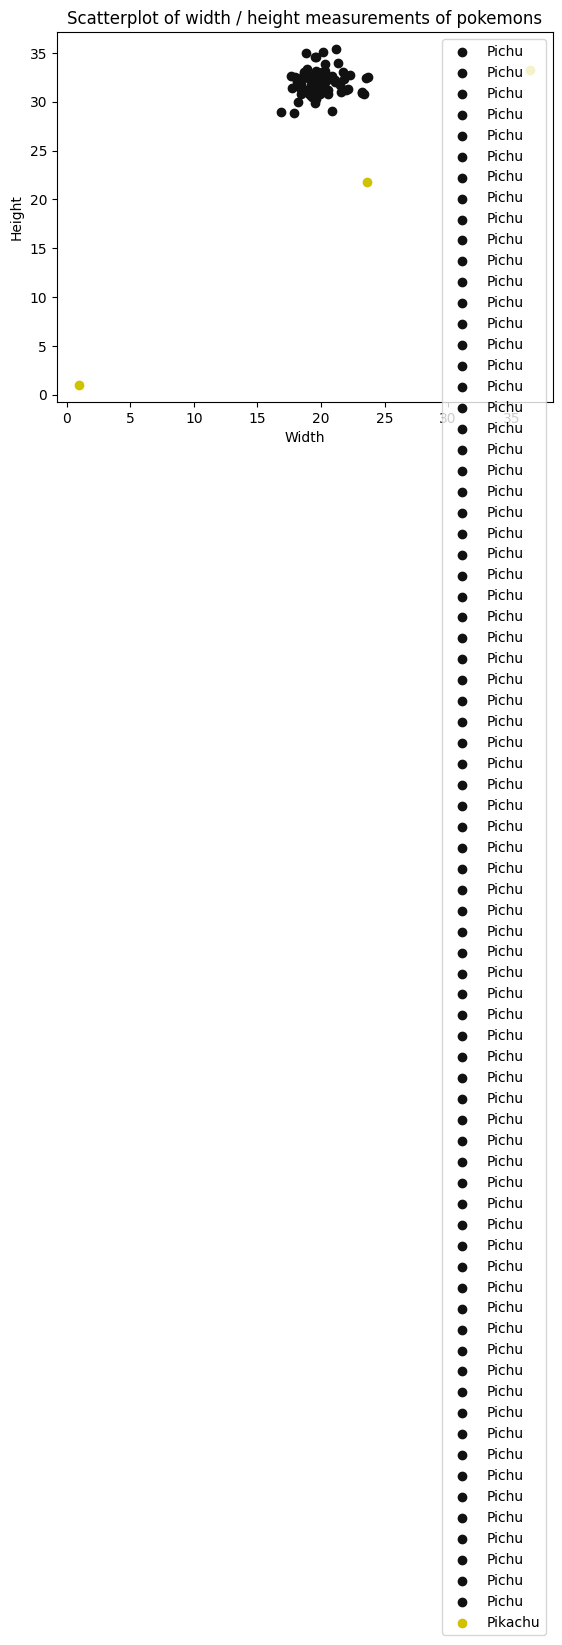

In [64]:
import matplotlib.pyplot as plt

pichu_list      = [pokemon for pokemon in datapoints if pokemon[2] == 0]
pikachu_list    = [pokemon for pokemon in datapoints if pokemon[2] == 1]

for pichu in pichu_list:
    plt.scatter(pichu[0], pichu[1], label = "Pichu", color = "#111111") # #889717 baby shit green
    
plt.scatter(pikachu_list[:][0], pikachu_list[:][1], label = "Pikachu", color = "#d0c101") # #d0c101 ugly yellow

plt.title("Scatterplot of width / height measurements of pokemons")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()

In [61]:
pichu_width   = [i[0] for i in pichu_list]
pichu_height  = [i[1] for i in pichu_list]

pikachu_width   = [i[0] for i in pikachu_list]
pikachu_height  = [i[1] for i in pikachu_list]
#print(f"{pikachu_width = }\n\n{pikachu_height = }")

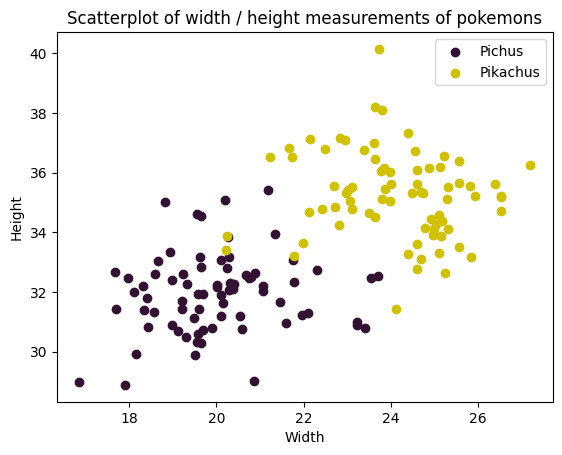

In [78]:
plt.scatter(pichu_width, pichu_height, color = "#331133", label = "Pichus")
plt.scatter(pikachu_width, pikachu_height, color = "#d0c101", label = "Pikachus") #d0c101 ugly yellow

plt.title("Scatterplot of width / height measurements of pokemons")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()

In [74]:
file_path = "assets/testpoints.txt"
with open(file_path, "r") as file_r:
    testpoints = [row[4:-2].split(", ") for row in file_r]
    testpoints.remove(testpoints[0])

print(testpoints)

[['25', '32'], ['24.2', '31.5'], ['22', '34'], ['20.5', '34']]


In [ ]:
# averages compared between datapoints and testdata

In [ ]:
# if average closer to pichu -> pichu
# else -> pikachu